# Übung 4.1 : Das Traglinienverfahren und die Prandtl'sche Tragflügeltheorie

<div style="text-align: justify"> </p>Die Übung 4 ist die erste von insgesamt fünf computer-basierten Übungen und soll einen ersten Einblick in aerodynamische Optimierungsaufgaben geben und wie sie mit Algorithmen gelöst werden können. </p>

Die **Prandtl'sche Traglinientheorie (engl. "lifting line theory")** besteht seit der Zeit des ersten Weltkrieges und findet heutzutage immernoch Anwendung. Darauf basierend wird das numerische Traglinienverfahren als analytische Methode eingesetzt, um im Flügel-Vorentwurf Vorhersagen über Effizienz und Verluste von Tragflügeln endlicher Streckung zu treffen.

#### Was liefert die Traglinientheorie?
- Auftriebsverteilung entlang der Spannweite
- Auftriebskraft 
- Induzierter Widerstand (Effizienz)

#### Was sind die Einschränkungen?
- gilt nur für große Streckungen
- Pfeilung kann nicht berücksichtigt werden 
- gilt nur für kleine Anstellwinkel

Die ausführliche Theorie zum Verfahren findet ihr in den Skripten begleitend zur Vorlesung. Nachfolgend soll nun exemplarisch gezeigt werden, wie ein solches Traglinienverfahren in Python implementiert werden kann
 </div>

In [1]:
# Importieren von Python-Biblioteken
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Fügt das parent diretory zum Python-Pfad hinzu, damit Dateien aus anderen Directories gelesen werden können
sys.path.append(os.path.abspath(os.path.join('..')))

# Importieren von Hilfsfunktionen
import helper_functions as hf

## Aufgabe 4.1 a)
Untersuchen Sie am Beispiel des Rechteckflügels mit $l_i=1$ und $\Lambda = 10$ das Konvergenzverhalten der aerodynamischen Beiwerte ($C_W$, $C_A$) und des Oswald Faktors hinsichtlich der Abhängigkeit von der Anzahl der Elementarflügel (räumliche Diskretisierung).
Entscheiden Sie sich für eine Diskretisierung für alle folgenden Aufgabenteil und begründen Sie diese Entscheidung.

### 4.1.1 Visualisierung: Doppeltrapezflügel

In [2]:
display(hf.widget_doppeltrapezfluegel())

### 4.1.2 Geometrische Parameter und Randbedinungen

In [3]:
# Konstant
alpha = 1.0             # Anstellwinel [rad]
U_inf = 10.0            # Anströmgeschwindigkeit [m/s]
rho = 1.225             # Dichte [kg/m^3]
l_i = 1.0               # Flügeltiefe Wurzel [m]

#### EINGABE

In [4]:
l_a = 0.5               # Flügeltiefe außen [m]
l_k = 0.8               # Flügeltiefe kink [m]
AR = 10                 # Streckung/ Aspect Ratio

#### Berechnung weiterer geometrischer Parameter

In [5]:
# Berechnung der Halbspannweite
b = AR * (l_k*0.75 + 0.5*(l_i-l_k)*0.75+l_a*(1-0.75)+0.5*(l_k-l_a)*0.25)   
s = b / 2 

# Berechnung der Kink-Position (bei 75% der Halbspannweite)
y_lk = 0.75 * s     

# Berechnung der Flügelfläche
S = b**2 / AR         

# Ausgabe
print("Spannweite:                  ", "%.2f" % b, "m")
print("Halbspannweite:              ", "%.2f" % s, "m")
print("Kink-Position:               ", "%.2f" % y_lk, "m")
print("Flügelfläche:                ", "%.2f" % S, "m^2")

Spannweite:                   8.38 m
Halbspannweite:               4.19 m
Kink-Position:                3.14 m
Flügelfläche:                 7.01 m^2


#### Vergleich mit elliptischer Planform

In [6]:
h_ell = l_i/2 * (np.sqrt(1 - (y_lk / s)))                                   # ???                   
S_ell = np.pi * l_i * 0.5 * s                                               # entsprechende Fläche
AR_ell = b**2 / S_ell                                                       # entsprechende Streckung

# Ausgabe
print("???:                         ", "%.2f" % h_ell, "m")
print("Flügelfläche:                ", "%.2f" % S_ell, "m^2")
print("Streckung:                   ", "%.2f" % AR_ell)

???:                          0.25 m
Flügelfläche:                 6.58 m^2
Streckung:                    10.66


### 4.1.4 Berechnung der Hufeisenwirbel-Koordinaten

Zur Bestimmung der $N$ (Variable n) unbekannten Wirbelstärken $\Gamma$ wird die kinematische Strömungsbedingung in den $N$ (Variable $m$) Aufpunkten erfüllt, und man hat ein lineares Gleichungssystem zu lösen. Dafür werden die Koordinaten des tragenden Wirbels entlang der örtlichen $l_p/4$-Linie (indizes a, b) am Rand jedes Elementarflügels sowie die der Aufpunkte im $3l_p/4$–Punkt des Mittelschnittes jedes Elementarflügels (index c) bestimmt.

In [7]:
# Visualisierung der Diskretisierung
hf.widget_diskretisierung_doppeltrapez(l_a, l_k, y_lk, AR, s)

#### EINGABE

In [8]:
# # Anzahl der Elementarflügel und Breite eines Elementarflügels
N = 500                         
delta_b = b/N                   

In [9]:
# Spannweitige Positionen der Punkte A, B und Aufpunkt C
y_a = np.array([-s +  j    * delta_b for j in range(N)])
y_b = np.array([-s + (j+1) * delta_b for j in range(N)])
y_c = np.array([-s + delta_b/2 + i*delta_b for i in range(N)])

# Tiefenposition der Punkte A und B und Aufpunkt C
def x_position(y, l_i, l_k, l_a, y_lk, aufpunkt=False):
    tiefe = 0.75 if aufpunkt else 0.25
    if abs(y) <= y_lk:
        return (abs(y)/y_lk * 0.5*(l_i-l_k) + tiefe*(l_i - abs(y)/y_lk * (l_i-l_k)))
    else:
        return (0.5*(l_i-l_k) + (abs(y)-y_lk)/(s-y_lk) * 0.5*(l_k-l_a) + tiefe*(l_k - (abs(y)-y_lk)/(s-y_lk)*(l_k-l_a)))
    
x_a = np.array([x_position(y_i, l_i, l_k, l_a, y_lk) for y_i in y_a])
x_b = np.array([x_position(y_i, l_i, l_k, l_a, y_lk) for y_i in y_b])
x_c = np.array([x_position(y_i, l_i, l_k, l_a, y_lk, True) for y_i in y_c])

# Spannweitige Positionen der bis ins Unendliche reichenden nichttragenden Wirbel
y_aoo = np.array([-s +  j    * delta_b for j in range(N)])
y_boo = np.array([-s + (j+1) * delta_b for j in range(N)])

# Tiefenposition der bis ins Unendliche reichenden nichttragenden Wirbel
x_aoo = x_a + 100*s
x_boo = x_b + 100*s

### 4.1.5 Berechnung der Koeffizientenmatrix

In [10]:
# initialisieren der Matrizen
a_AB = np.zeros((x_a.size, x_a.size))
a_Aoo = np.zeros((x_a.size, x_a.size))
a_Boo = np.zeros((x_a.size, x_a.size))

for j in range(N):
    for i in range(N):
        a_AB[i, j] = 1 / (4*np.pi) * (1/((x_c[i] - x_a[j])*(y_c[i] - y_b[j]) - (y_c[i] - y_a[j])*(x_c[i] - x_b[j]))) * (((x_b[j] - x_a[j])*(x_c[i] - x_a[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_a[j]))/ np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2) - ((x_b[j] - x_a[j])*(x_c[i] - x_b[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_b[j]))/ np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2))

for j in range(N):
    for i in range(N):
        a_Aoo[i, j] = 1 / (4*np.pi) * 1/(y_a[j] - y_c[i]) * ((x_c[i] - x_a[j])/ (np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2)) + 1)

for j in range(N):
    for i in range(N):
        a_Boo[i, j] = 1 / (4*np.pi) * 1/(y_b[j] - y_c[i]) * ((x_c[i] - x_b[j])/ (np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2)) + 1)

In [11]:
a = a_AB + a_Aoo - a_Boo                # Koeffizientenmatrix
a_ind = a_Aoo - a_Boo                   # Koeffizientenmatrix der induzierenden Wirbel
alpha_g = np.full((x_a.size), alpha)    # Anstellwinkelvektor

# die Wirbelstärken werden aus Inverser der Koeffizientenmatrix, Anstellwinkelvektor und Anströmgeschwindigkeit berechnet
Gamma = np.linalg.inv(a) * alpha_g * (- U_inf)

### 4.1.6 Berechnung von Kräften und Beiwerten

In [12]:
# Berechnung des Auftriebs nach Kutta-Joukowsky
A_j = rho * delta_b * U_inf * Gamma
A = np.sum(A_j)

# Berechnung des induzierten Widerstands
w_m = a_ind * Gamma
W_ind = np.sum(-rho *w_m * Gamma * delta_b)

print("Auftrieb:                    ", "%.2f" % A, "N")
print("Induzierter Widerstand:      ", "%.2f" % W_ind, "N")

Auftrieb:                     2138.85 N
Induzierter Widerstand:       103.99 N


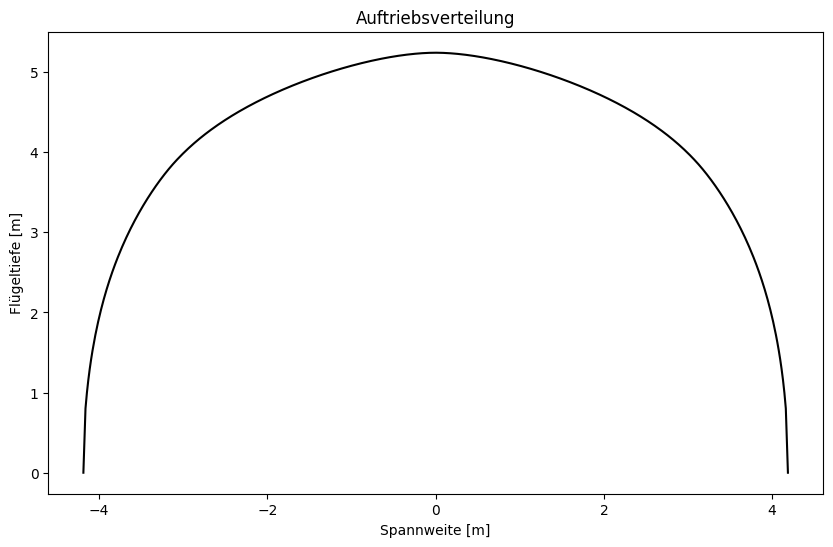

In [13]:
# Auftriebsverteilung plotten
hf.plot_auftriebsverteilung(A_j, y_c, s)

In [14]:
# Auftriebsbeiwert
C_A = 2*A / (rho * U_inf**2 * S)

# Für alpha= 1 [rad] entspricht C_A dem Auftriebsanstieg wegen C_A = C_A_alpha * alpha
# Als Vergleichswert dient die Näherungslösung
C_A_alpha = 2*np.pi * AR / (2+AR)

# Widerstandsbeiwert (induziert)
C_W_ind = 2*W_ind / (rho * U_inf**2 * S)

print("Auftriebsbeiwert:            ", "%.2f" % C_A)
print("Auftriebsanstieg:            ", "%.2f" % C_A_alpha)
print("Widerstandsbeiwert:          ", "%.2f" % C_W_ind)

Auftriebsbeiwert:             4.98
Auftriebsanstieg:             5.24
Widerstandsbeiwert:           0.24


In [15]:
# Induzierter Widerstand der elliptischen Zirkulationsverteilung
C_W_ind_ell = C_A**2 / AR / np.pi

# Oswald Faktor
Oswald = C_W_ind_ell / C_W_ind

print("Widerstandsbeiwert (Ellipse):", "%.2f" % C_W_ind_ell)
print("Oswald-Faktor:               ", "%.2f" % Oswald)

Widerstandsbeiwert (Ellipse): 0.79
Oswald-Faktor:                3.26
